In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import os

# List top-level folders and files
os.listdir('/content/drive/MyDrive/BoolQ_Project')


['boolq_finetuned_bert_best',
 'boolq_finetuned_bert_best_current',
 'train_df_clean.csv',
 'dev_df_clean.csv',
 'test_df_clean.csv',
 'boolq_test_predictions_epoch3.csv',
 'boolq_test_predictions.csv',
 'boolq_test_predictions_bert.csv',
 'boolq_finetuned_roberta_best',
 'boolq_finetuned_distilbert_best',
 'boolq_test_predictions_roberta.csv',
 'PubMedQA',
 'pubmedqa_dev.csv',
 'pubmedqa_train.csv',
 'roberta_tapt_pubmedqa',
 'pubmedqa_passages_full.txt',
 'pubmedqa_passages_10k.txt',
 'roberta_pubmedqa_finetuned_10k',
 'roberta_tapt_pubmedqa_10k',
 'pubmedqa_eval_metrics.txt',
 'pubmedqa_dev_with_predictions.csv',
 'pubmedqa_eval_metrics_boolq_only.txt',
 'pubmedqa_dev_preds_boolq.csv',
 'roberta_pubmedqa_finetuned_6k',
 'pubmedqa_eval_metrics_tapt6.txt',
 'pubmedqa_dev_preds_tapt6.csv',
 'pubmedqa_model_comparison.csv',
 'pubmedqa_test_predictions_10k.csv',
 'pubmedqa_test_metrics_10k.txt']

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch

drive_path = "/content/drive/My Drive/BoolQ_Project/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your fine-tuned model
roberta_model_10k = RobertaForSequenceClassification.from_pretrained(
    drive_path + 'roberta_pubmedqa_finetuned_10k'
)
roberta_tokenizer_10k = RobertaTokenizer.from_pretrained(
    drive_path + 'roberta_pubmedqa_finetuned_10k'
)
roberta_model_10k.to(device)
print("✅ Model and tokenizer loaded successfully.")


✅ Model and tokenizer loaded successfully.


In [ ]:
import pandas as pd

# Load dev set
dev_df = pd.read_csv('/content/drive/My Drive/BoolQ_Project/pubmedqa_dev.csv')
dev_df['answer'] = dev_df['answer'].astype(int)


In [ ]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler

class PubMedQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        question = self.data.iloc[index]['question']
        passage = self.data.iloc[index]['passage']
        inputs = self.tokenizer(
            question,
            passage,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['labels'] = torch.tensor(self.data.iloc[index]['answer'], dtype=torch.long)
        return item

# Recreate dataset and loader
dev_dataset = PubMedQADataset(dev_df, roberta_tokenizer_10k)
dev_loader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=8)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# Evaluate
roberta_model_10k.eval()
dev_preds, dev_labels = [], []

with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = roberta_model_10k(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        dev_preds.extend(preds.cpu().numpy())
        dev_labels.extend(labels.cpu().numpy())

# Metrics
acc = accuracy_score(dev_labels, dev_preds)
f1 = f1_score(dev_labels, dev_preds)

# Save
with open('/content/pubmedqa_eval_metrics.txt', 'w') as f:
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")

!cp /content/pubmedqa_eval_metrics.txt "{drive_path}/"
print(f"Eval metrics saved to Drive.\nAccuracy: {acc:.4f}, F1: {f1:.4f}")


Evaluating:   7%|▋         | 10/150 [00:02<00:33,  4.21it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating:   7%|▋         | 11/150 [00:03<00:32,  4.23it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some to

Eval metrics saved to Drive.
Accuracy: 0.8983, F1: 0.9408


In [ ]:
dev_df['predicted_answer'] = dev_preds
dev_df.to_csv('/content/pubmedqa_dev_with_predictions.csv', index=False)
!cp /content/pubmedqa_dev_with_predictions.csv "{drive_path}/"
print("Predictions saved to Drive.")

Predictions saved to Drive.


Evaluate BoolQ-Only RoBERTa on PubMedQA

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load BoolQ-only model
boolq_model = RobertaForSequenceClassification.from_pretrained(
    drive_path + 'boolq_finetuned_roberta_best'
)
boolq_tokenizer = RobertaTokenizer.from_pretrained(
    drive_path + 'boolq_finetuned_roberta_best'
)
boolq_model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Reuse PubMedQA dev set
dev_dataset_boolq = PubMedQADataset(dev_df, boolq_tokenizer)
dev_loader_boolq = DataLoader(dev_dataset_boolq, sampler=SequentialSampler(dev_dataset_boolq), batch_size=8)

# Evaluate
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

boolq_model.eval()
dev_preds_boolq, dev_labels_boolq = [], []

with torch.no_grad():
    for batch in tqdm(dev_loader_boolq, desc="BoolQ-only Dev Eval"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = boolq_model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        dev_preds_boolq.extend(preds.cpu().numpy())
        dev_labels_boolq.extend(labels.cpu().numpy())

acc_boolq = accuracy_score(dev_labels_boolq, dev_preds_boolq)
f1_boolq = f1_score(dev_labels_boolq, dev_preds_boolq)

# Save
with open('/content/pubmedqa_eval_metrics_boolq_only.txt', 'w') as f:
    f.write(f"Accuracy: {acc_boolq:.4f}\nF1 Score: {f1_boolq:.4f}\n")
!cp /content/pubmedqa_eval_metrics_boolq_only.txt "{drive_path}/"

# Save predictions
dev_df['predicted_answer_boolq'] = dev_preds_boolq
dev_df.to_csv('/content/pubmedqa_dev_preds_boolq.csv', index=False)
!cp /content/pubmedqa_dev_preds_boolq.csv "{drive_path}/"

print(f"BoolQ-only RoBERTa → Dev Accuracy: {acc_boolq:.4f}, F1: {f1_boolq:.4f}")


BoolQ-only Dev Eval:   7%|▋         | 10/150 [00:02<00:32,  4.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
BoolQ-only Dev Eval:   7%|▋         | 11/150 [00:02<00:32,  4.23it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be emp

BoolQ-only RoBERTa → Dev Accuracy: 0.8442, F1: 0.9131


Load Model + Tokenizer (TAPT-6K)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load TAPT-6K model (not yet fine-tuned)
tapt6_model = RobertaForSequenceClassification.from_pretrained(
    drive_path + 'roberta_tapt_pubmedqa',
    num_labels=2
)
tapt6_tokenizer = RobertaTokenizer.from_pretrained(
    drive_path + 'roberta_tapt_pubmedqa'
)
tapt6_model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/BoolQ_Project/roberta_tapt_pubmedqa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Reuse existing pubmedqa_train.csv and pubmedqa_dev.csv
train_df = pd.read_csv(drive_path + 'pubmedqa_train.csv')
dev_df = pd.read_csv(drive_path + 'pubmedqa_dev.csv')

train_df['answer'] = train_df['answer'].astype(int)
dev_df['answer'] = dev_df['answer'].astype(int)

# Rebuild dataset
train_dataset_tapt6 = PubMedQADataset(train_df, tapt6_tokenizer)
dev_dataset_tapt6 = PubMedQADataset(dev_df, tapt6_tokenizer)

train_loader_tapt6 = DataLoader(train_dataset_tapt6, sampler=RandomSampler(train_dataset_tapt6), batch_size=8)
dev_loader_tapt6 = DataLoader(dev_dataset_tapt6, sampler=SequentialSampler(dev_dataset_tapt6), batch_size=8)


In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

optimizer = AdamW(tapt6_model.parameters(), lr=2e-5)
num_training_steps = len(train_loader_tapt6) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_f1 = 0
for epoch in range(3):
    print(f"\n🔥 TAPT-6K Epoch {epoch + 1}/3")
    tapt6_model.train()
    total_loss = 0

    for batch in tqdm(train_loader_tapt6, desc="Training TAPT-6K"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = tapt6_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tapt6_model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader_tapt6)
    print(f"📉 Avg Train Loss: {avg_train_loss:.4f}")

    # Evaluation
    tapt6_model.eval()
    dev_preds, dev_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dev_loader_tapt6, desc="Evaluating TAPT-6K"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = tapt6_model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(labels.cpu().numpy())

    acc_tapt6 = accuracy_score(dev_labels, dev_preds)
    f1_tapt6 = f1_score(dev_labels, dev_preds)
    print(f"✅ TAPT-6K Dev Accuracy: {acc_tapt6:.4f}, F1: {f1_tapt6:.4f}")

    if f1_tapt6 > best_f1:
        best_f1 = f1_tapt6
        tapt6_model.save_pretrained('/content/roberta_pubmedqa_finetuned_6k')
        tapt6_tokenizer.save_pretrained('/content/roberta_pubmedqa_finetuned_6k')
        !cp -r /content/roberta_pubmedqa_finetuned_6k "{drive_path}/"
        print(f"🎯 New best TAPT-6K model saved (F1 = {f1_tapt6:.4f})")



🔥 TAPT-6K Epoch 1/3


Training TAPT-6K:   0%|          | 2/600 [00:02<09:01,  1.10it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Training TAPT-6K:   4%|▎         | 22/600 [00:18<08:06,  1.19it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even

📉 Avg Train Loss: 0.4190


Evaluating TAPT-6K:   7%|▋         | 10/150 [00:02<00:34,  4.06it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating TAPT-6K:   7%|▋         | 11/150 [00:03<00:34,  4.01it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty

✅ TAPT-6K Dev Accuracy: 0.8483, F1: 0.9179
🎯 New best TAPT-6K model saved (F1 = 0.9179)

🔥 TAPT-6K Epoch 2/3


Training TAPT-6K:   2%|▏         | 9/600 [00:06<07:42,  1.28it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Training TAPT-6K:  13%|█▎        | 77/600 [01:00<06:52,  1.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even

📉 Avg Train Loss: 0.3899


Evaluating TAPT-6K:   7%|▋         | 10/150 [00:02<00:35,  3.96it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating TAPT-6K:   7%|▋         | 11/150 [00:03<00:35,  3.92it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty

✅ TAPT-6K Dev Accuracy: 0.8108, F1: 0.8907

🔥 TAPT-6K Epoch 3/3


Training TAPT-6K:   2%|▏         | 9/600 [00:06<07:44,  1.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Training TAPT-6K:   2%|▏         | 12/600 [00:09<07:46,  1.26it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even

📉 Avg Train Loss: 0.3723


Evaluating TAPT-6K:   7%|▋         | 10/150 [00:02<00:36,  3.86it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating TAPT-6K:   7%|▋         | 11/150 [00:03<00:36,  3.84it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty

✅ TAPT-6K Dev Accuracy: 0.8375, F1: 0.9088


In [ ]:
# Reload best TAPT-6K model (just to be safe)
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tapt6_model = RobertaForSequenceClassification.from_pretrained(
    '/content/roberta_pubmedqa_finetuned_6k'
)
tapt6_tokenizer = RobertaTokenizer.from_pretrained(
    '/content/roberta_pubmedqa_finetuned_6k'
)
tapt6_model.to(device)
tapt6_model.eval()

In [ ]:
dev_dataset_tapt6 = PubMedQADataset(dev_df, tapt6_tokenizer)
dev_loader_tapt6 = DataLoader(dev_dataset_tapt6, sampler=SequentialSampler(dev_dataset_tapt6), batch_size=8)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

dev_preds_tapt6, dev_labels_tapt6 = [], []

with torch.no_grad():
    for batch in tqdm(dev_loader_tapt6, desc="Evaluating TAPT-6K"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = tapt6_model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        dev_preds_tapt6.extend(preds.cpu().numpy())
        dev_labels_tapt6.extend(labels.cpu().numpy())

acc_tapt6 = accuracy_score(dev_labels_tapt6, dev_preds_tapt6)
f1_tapt6 = f1_score(dev_labels_tapt6, dev_preds_tapt6)

# Save metrics
with open('/content/pubmedqa_eval_metrics_tapt6.txt', 'w') as f:
    f.write(f"Accuracy: {acc_tapt6:.4f}\nF1 Score: {f1_tapt6:.4f}\n")

!cp /content/pubmedqa_eval_metrics_tapt6.txt "{drive_path}/"
print(f"TAPT-6K metrics saved — Accuracy: {acc_tapt6:.4f}, F1: {f1_tapt6:.4f}")

Evaluating TAPT-6K:   7%|▋         | 10/150 [00:02<00:33,  4.22it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Evaluating TAPT-6K:   7%|▋         | 11/150 [00:02<00:33,  4.20it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty

TAPT-6K metrics saved — Accuracy: 0.8483, F1: 0.9179


In [ ]:
dev_df['predicted_answer_tapt6'] = dev_preds_tapt6
dev_df.to_csv('/content/pubmedqa_dev_preds_tapt6.csv', index=False)
!cp /content/pubmedqa_dev_preds_tapt6.csv "{drive_path}/"
print("📄 TAPT-6K predictions saved to Drive.")

📄 TAPT-6K predictions saved to Drive.


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['BoolQ-only RoBERTa', 'TAPT-6K RoBERTa', 'TAPT-10K RoBERTa'],
    'Accuracy': [acc_boolq, acc_tapt6, acc],
    'F1 Score': [f1_boolq, f1_tapt6, f1]
})

results_df.to_csv('/content/pubmedqa_model_comparison.csv', index=False)
!cp /content/pubmedqa_model_comparison.csv "{drive_path}/"
print("📊 Updated comparison table saved to Drive.")
results_df

📊 Updated comparison table saved to Drive.


,Model,Accuracy,F1 Score
0,BoolQ-only RoBERTa,0.844167,0.913144
1,TAPT-6K RoBERTa,0.848333,0.917944
2,TAPT-10K RoBERTa,0.898333,0.940777


In [ ]:
import json
import pandas as pd

# Load test labels
with open(drive_path + 'PubMedQA/test_ground_truth.json', 'r') as f:
    test_gt = json.load(f)

print(f"Loaded {len(test_gt)} test samples")


Loaded 500 test samples


In [ ]:
# Load the content data
with open(drive_path + 'PubMedQA/ori_pqal.json', 'r') as f:
    pqal_data = json.load(f)

# Build test dataframe
test_rows = []
for pubmed_id, label in test_gt.items():
    if pubmed_id in pqal_data:
        question = pqal_data[pubmed_id]['QUESTION']
        passage = ' '.join(pqal_data[pubmed_id]['CONTEXTS'])
        test_rows.append({
            'pubmed_id': pubmed_id,
            'question': question,
            'passage': passage,
            'answer': 1 if label == 'yes' else 0
        })

test_df = pd.DataFrame(test_rows)
print(f"Final test set shape: {test_df.shape}")


Final test set shape: (500, 4)


In [ ]:
test_dataset = PubMedQADataset(test_df, roberta_tokenizer_10k)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=8)

In [ ]:
roberta_model_10k.eval()
test_preds = []
true_labels = test_df['answer'].tolist()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = roberta_model_10k(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())

Predicting on test set:   8%|▊         | 5/63 [00:01<00:13,  4.27it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Predicting on test set: 100%|██████████| 63/63 [00:14<00:00,  4.33it/s]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

acc_test = accuracy_score(true_labels, test_preds)
f1_test = f1_score(true_labels, test_preds)

# Save predictions
test_df['predicted_answer'] = test_preds
test_df.to_csv('/content/pubmedqa_test_predictions_10k.csv', index=False)
!cp /content/pubmedqa_test_predictions_10k.csv "{drive_path}/"

# Save metrics
with open('/content/pubmedqa_test_metrics_10k.txt', 'w') as f:
    f.write(f"Test Accuracy: {acc_test:.4f}\n")
    f.write(f"Test F1 Score: {f1_test:.4f}\n")
!cp /content/pubmedqa_test_metrics_10k.txt "{drive_path}/"

print(f"Test evaluation complete! Accuracy: {acc_test:.4f}, F1: {f1_test:.4f}")

Test evaluation complete! Accuracy: 0.8400, F1: 0.8592


BAR CHART: Compare Accuracy & F1

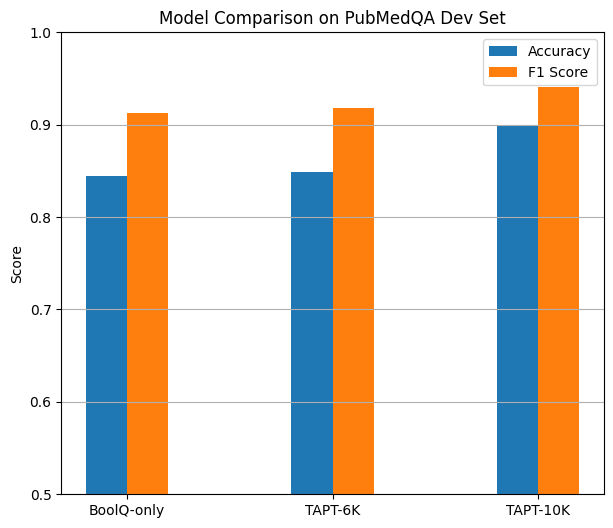

In [ ]:
import matplotlib.pyplot as plt

model_names = ['BoolQ-only', 'TAPT-6K', 'TAPT-10K']
accuracies = [acc_boolq, acc_tapt6, acc]
f1_scores = [f1_boolq, f1_tapt6, f1]

x = range(len(model_names))
width = 0.2

plt.figure(figsize=(7, 6))
plt.bar(x, accuracies, width=width, label='Accuracy')
plt.bar([i + width for i in x], f1_scores, width=width, label='F1 Score')
plt.xticks([i + width/2 for i in x], model_names)
plt.ylim(0.5, 1.0)
plt.ylabel('Score')
plt.title('Model Comparison on PubMedQA Dev Set')
plt.legend()
plt.grid(axis='y')
plt.show()


## BERT on BoolQ - Loss & F1 over Epochs

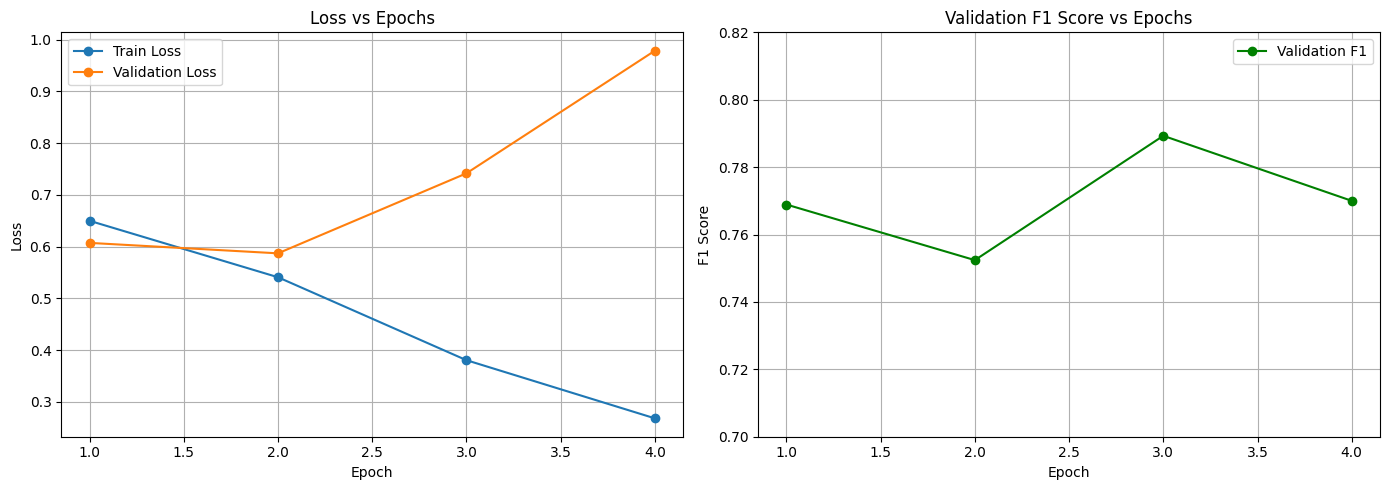

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4]
train_loss = [0.6499, 0.5408, 0.3805, 0.2681]
val_loss = [0.6072, 0.5870, 0.7416, 0.9786]
val_f1 = [0.7689, 0.7524, 0.7893, 0.7700]

plt.figure(figsize=(14, 5))

# Train & Val Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Dev F1 Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1, color='green', label='Validation F1', marker='o')
plt.title('Validation F1 Score vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0.7, 0.82)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## RoBERTa on BoolQ

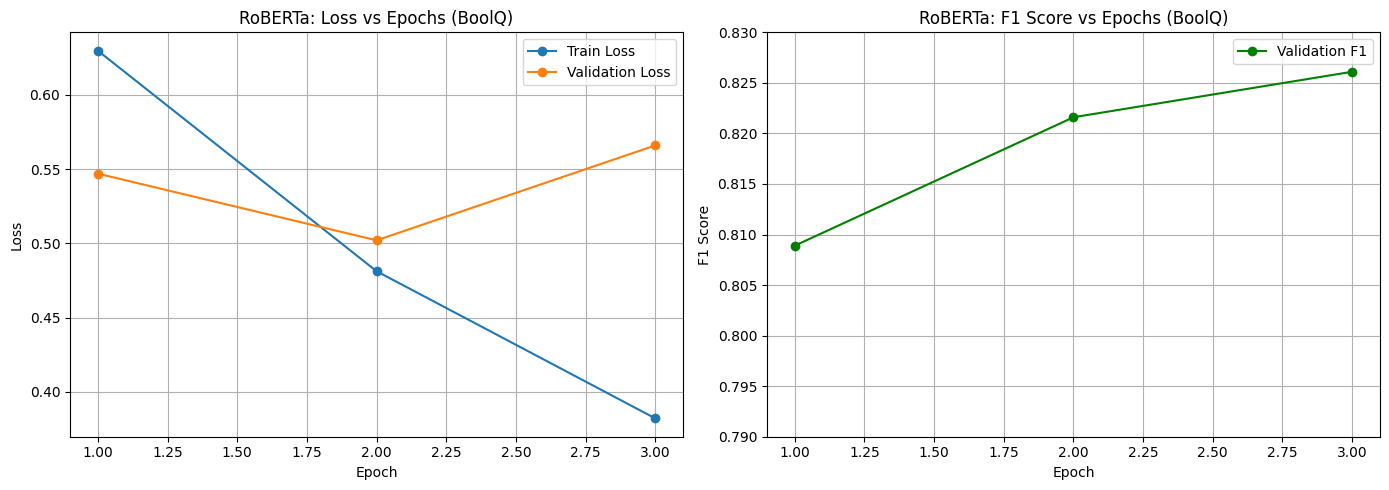

In [ ]:
import matplotlib.pyplot as plt

# Data extracted from RoBERTa logs on BoolQ
epochs = [1, 2, 3]
train_loss_roberta = [0.6298, 0.4813, 0.3822]
val_loss_roberta = [0.5470, 0.5021, 0.5660]
val_f1_roberta = [0.8089, 0.8216, 0.8261]

# Plotting
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_roberta, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_roberta, label='Validation Loss', marker='o')
plt.title('RoBERTa: Loss vs Epochs (BoolQ)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# F1 Score Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1_roberta, color='green', label='Validation F1', marker='o')
plt.title('RoBERTa: F1 Score vs Epochs (BoolQ)')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0.79, 0.83)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## DistilBERT on BoolQ

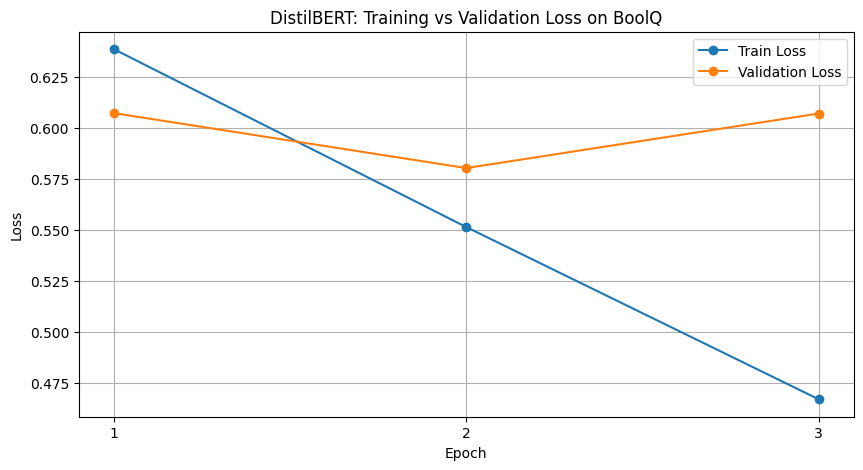

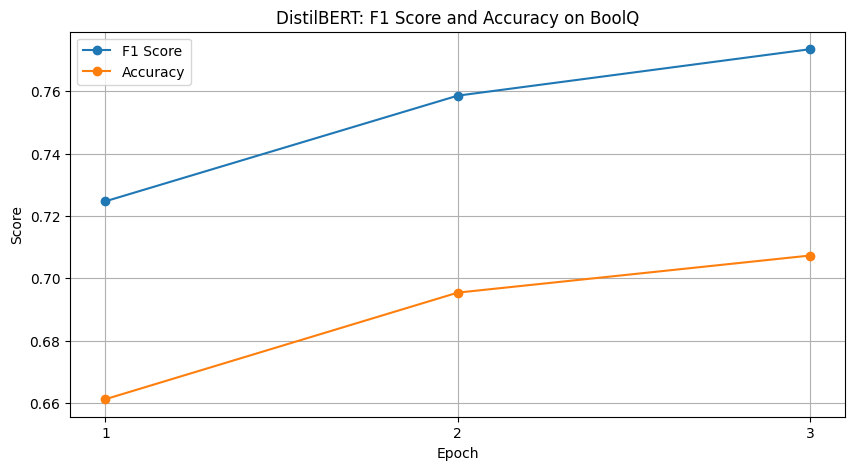

In [ ]:
import matplotlib.pyplot as plt

# Data extracted from DistilBERT over BoolQ logs
epochs = [1, 2, 3]
train_loss = [0.6386, 0.5515, 0.4672]
val_loss = [0.6073, 0.5804, 0.6071]
f1_scores = [0.7247, 0.7586, 0.7735]
accuracy = [0.6612, 0.6954, 0.7073]

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('DistilBERT: Training vs Validation Loss on BoolQ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plotting F1 Score and Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_scores, marker='o', label='F1 Score')
plt.plot(epochs, accuracy, marker='o', label='Accuracy')
plt.title('DistilBERT: F1 Score and Accuracy on BoolQ')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


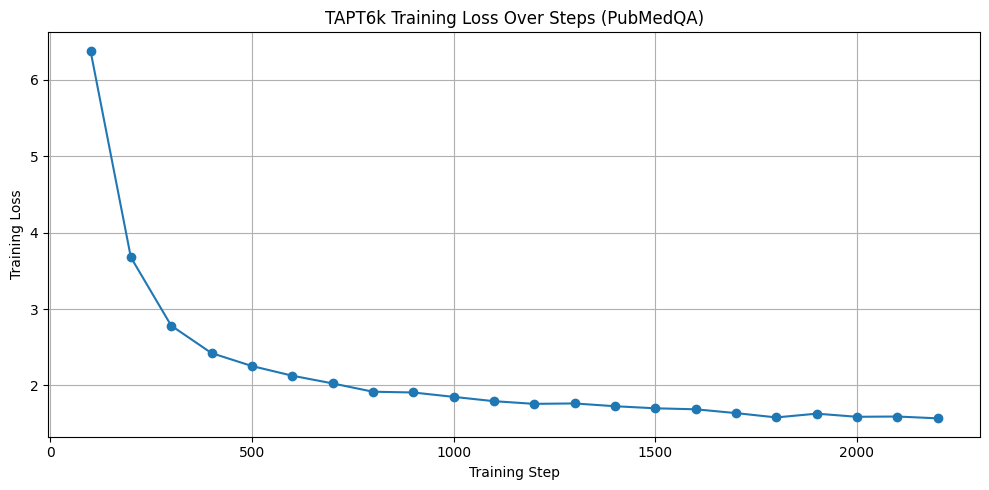

In [ ]:
import matplotlib.pyplot as plt

# TAPT6k training loss data
steps = [
    100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
    1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200
]
losses = [
    6.3812, 3.6775, 2.783, 2.4235, 2.2544, 2.1279, 2.027,
    1.9182, 1.9079, 1.8507, 1.7942, 1.7591, 1.7646,
    1.7282, 1.7012, 1.688, 1.6383, 1.5816, 1.6308,
    1.5899, 1.5935, 1.5696
]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o')
plt.title("TAPT6k Training Loss Over Steps (PubMedQA)")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


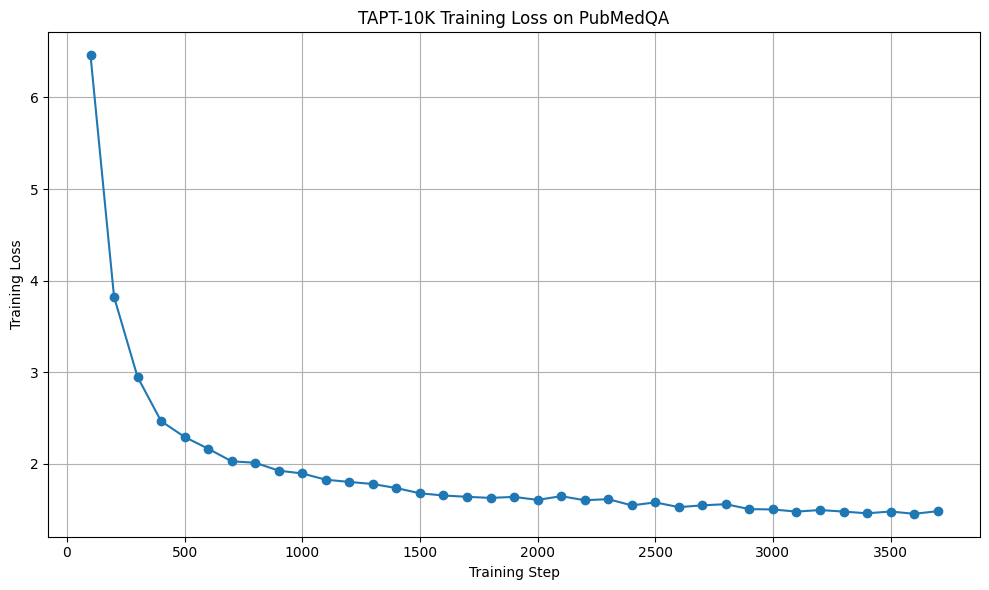

In [ ]:
import matplotlib.pyplot as plt

# Step numbers and training losses from TAPT-10K
steps = list(range(100, 3800, 100))
losses = [
    6.4613, 3.8220, 2.9461, 2.4642, 2.2912, 2.1631, 2.0252, 2.0096, 1.9234, 1.8926,
    1.8244, 1.8001, 1.7772, 1.7329, 1.6760, 1.6519, 1.6375, 1.6256, 1.6366, 1.6037,
    1.6445, 1.6003, 1.6120, 1.5440, 1.5766, 1.5248, 1.5443, 1.5570, 1.5030, 1.4993,
    1.4758, 1.4932, 1.4761, 1.4575, 1.4769, 1.4520, 1.4804
]

# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o')
plt.title('TAPT-10K Training Loss on PubMedQA')
plt.xlabel('Training Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


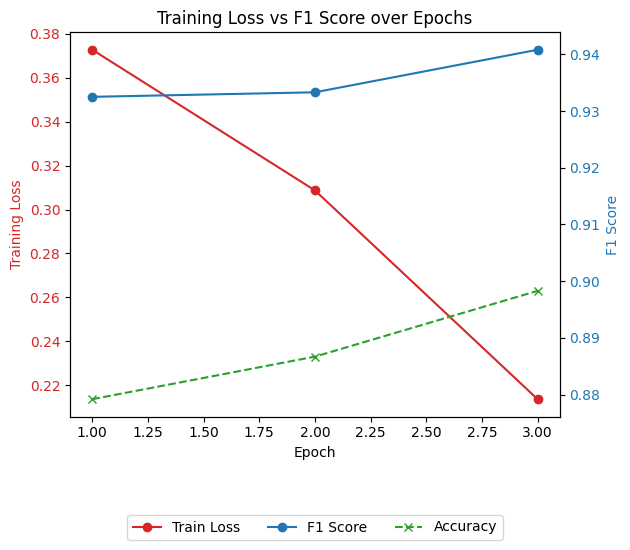

In [ ]:
import matplotlib.pyplot as plt

# Data from your log
epochs = [1, 2, 3]
train_loss = [0.3727, 0.3087, 0.2137]
f1_score = [0.9325, 0.9333, 0.9408]
accuracy = [0.8792, 0.8867, 0.8983]

# Plot
fig, ax1 = plt.subplots()

# Plot training loss
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss", color="tab:red")
ax1.plot(epochs, train_loss, label="Train Loss", color="tab:red", marker="o")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create second y-axis for F1 score
ax2 = ax1.twinx()
ax2.set_ylabel("F1 Score", color="tab:blue")
ax2.plot(epochs, f1_score, label="F1 Score", color="tab:blue", marker="o")
ax2.plot(epochs, accuracy, label="Accuracy", color="tab:green", linestyle="--", marker="x")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Titles and legends
plt.title("Training Loss vs F1 Score over Epochs")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()


In [ ]:
# Save to local (in case it's not already)
roberta_model_10k.save_pretrained('/content/roberta_pubmedqa_finetuned_10k')
roberta_tokenizer_10k.save_pretrained('/content/roberta_pubmedqa_finetuned_10k')

# Copy to Drive
!cp -r /content/roberta_pubmedqa_finetuned_10k "{drive_path}/"

In [ ]:
tapt6_model.save_pretrained('/content/roberta_pubmedqa_finetuned_6k')
tapt6_tokenizer.save_pretrained('/content/roberta_pubmedqa_finetuned_6k')

!cp -r /content/roberta_pubmedqa_finetuned_6k "{drive_path}/"


In [ ]:
boolq_model.save_pretrained('/content/boolq_finetuned_roberta_best')
boolq_tokenizer.save_pretrained('/content/boolq_finetuned_roberta_best')

!cp -r /content/boolq_finetuned_roberta_best "{drive_path}/"
